# Bonate (2011): Pharmacokinetic-Pharmacodynamic Modeling and Simulations

Here, we replicate some of the examples described in Bonate (2011). I recommend following along with the 2nd edition of the book. The purpose of this notebook is to illustrate the versatility of `delicatessen` by illustrating its application for pharmacokinetic modeling. This can easily be done by using the built-in estimating equations, as will be shown.

Bonate PL. (2011). Pharmacokinetic-Pharmacodynamic Modeling and Simulations. 2nd Edition. Springer, New York, NY.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_emax, ee_glm

np.random.seed(80950841)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Delicatessen version:", delicatessen.__version__)

NumPy version:        1.25.2
SciPy version:        1.11.2
Pandas version:       1.4.1
Delicatessen version: 3.2


## Chapter 4: Variance Models, Weighting, and Transformations

The first example comes from Chapter 4. Data comes from Table 9 (pg 153) from a study by Byers et al. (1989) on XomaZyme-791 dose on percent change in albumin concentration among 17 patients. Note that this number of patients may be below what is considered sufficient for inference with the sandwich. 

The E-max model is described by
$$ R_i = E_0 + (E_{m} - E_0) \frac{D_i}{ED_{50} + D_i} $$
where $D$ is the dose, $R$ is the response, $E_0$ is the response at a dose of zero, $E_m$ is the maximum response, and $ED_{50}$ is the halfway maximal dose. Here, $E_0 = 0$ so the E-max model reduces to
$$ R_i = E_{m} \frac{D_i}{ED_{50} + D_i} $$
This is the model we will consider.

The corresponding data is presented below

In [2]:
d = [5, 5, 13, 11, 14.5, 6.8, 42.5, 37.5, 25, 38, 40, 26.5, 27.7, 27.4, 45, 61.4, 52.8]
r = [-12, -13, -28, -24, -45, -18, -26, -40, -45, -26, -29, -26, -22, -28, -36, -27, -48]

In the book, a two parameter E-max model is used. The first parameter is maximum response and the second is the 50% effective dose. The minimum dose will be set as zero (i.e., not estimated) since there is no data on a dose of zero. 

Here, we will apply the same linear model described in the book (i.e., prior to the Box-Cox transformation). This can be done using the `ee_emax` built-in estimating equation. But before that, we will plot the dose-response data. This is an important step, as it will help us decided on starting values for the root-finding procedure

(0.0, 70.0)

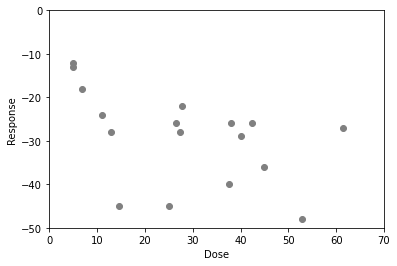

In [3]:
plt.plot(d, r, 'o', color='gray')
plt.xlabel("Dose")
plt.ylim([-50, 0])
plt.ylabel("Response")
plt.xlim([0, 70])

Given this dose-response data, it appears that the dose-response begins to asymptote at some point beyond a dose of 10. Therefore, we should select a starting value of $ED_{50}$ below 10. Further, a maximum response value between -30 and -50 seems reasonable, so we will select -40 as the max effect starting value.

In [4]:
def psi(theta):
    lower = 0
    vals = [0., ] + list(theta)
    return ee_emax(theta=vals, dose=d, response=r)[1:, :]

In [5]:
estr = MEstimator(psi, init=[-40, 5])
estr.estimate()

In [6]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["E-max", "ED50"]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(1)

,Est,SE,LCL,UCL
Params,,,,
E-max,-38.6,4.1,-46.7,-30.5
ED50,6.2,2.4,1.5,10.9


These results are close to what is reported in the book (note that a different variance estimator is used). 

We can also use these parameters to generate a plot.

(0.0, 70.0)

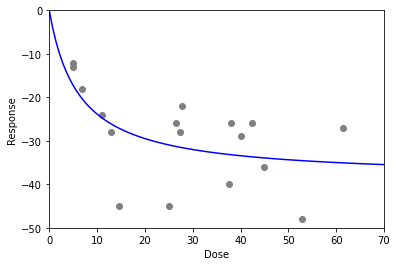

In [7]:
x = np.linspace(0, 70, 100)
y = estr.theta[0] * x / (estr.theta[1] + x)

plt.plot(d, r, 'o', color='gray')
plt.plot(x, y, '-', color='blue')
plt.xlabel("Dose")
plt.ylim([-50, 0])
plt.ylabel("Response")
plt.xlim([0, 70])

## Chapter 11: Generalized Linear Models and Its Extensions


### Adverse Events Case Study

The first example from Chapter 11 is the *Case Study: Assessing the Relationship Between Drug Concentrations and Adverse Events Using Logistic Regression*. Data comes from Table 2 of the book. In the book, a variety of different models for different adverse events are considered. Here, we only consider nausea (and vomiting) by AUC. For the one observations with a missing AUC value, they are dropped from the data set (same as the book). For ease of examining the coefficients, we will also divide the AUC value by 1000. This means the coefficients for AUC are rescaled from those reported in the book.

First, we load the data set and transform the coefficients and add an intercept column to the data set

In [8]:
d = pd.read_csv("data/bonate.csv").dropna()
d['intercept'] = 1   # Adding intercept to data
d['auc'] /= 1000     # Rescaling AUC
d['c_max'] /= 1000   # Rescaling C_max
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 42
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         42 non-null     int64  
 1   c_max      42 non-null     float64
 2   auc        42 non-null     float64
 3   age        42 non-null     int64  
 4   sex        42 non-null     int64  
 5   ps         42 non-null     int64  
 6   myalgia    42 non-null     int64  
 7   phlebitis  42 non-null     int64  
 8   asthenia   42 non-null     int64  
 9   diarrhea   42 non-null     int64  
 10  nausea     42 non-null     int64  
 11  intercept  42 non-null     int64  
dtypes: float64(2), int64(10)
memory usage: 4.3 KB


In [9]:
table = pd.DataFrame(columns=["Model", "Intercept", "AUC", "Sex", "Age", "PS"])

To begin, we will fit a null (intercept-only) logistic regression model. This is easily done by using the built-in `ee_glm` estimating equation. For the logistic model, we specify a binomial distribution with the logit link. Below is code to setup the estimating equation and then estimate the parameters using `MEstimator`

In [10]:
def psi(theta):
    # Estimating equation for null model
    return ee_glm(theta=theta,
                  y=d['nausea'],
                  X=d[['intercept', ]],
                  distribution='binomial',
                  link='logit')


# Estimate the parameters of the logit model
estr_null = MEstimator(psi, init=[0., ])
estr_null.estimate()

# Adding results to the output table
table.loc[len(table)] = ["Null", estr_null.theta[0], ] + [np.nan, ]*4

Next we fit a logistic regression model that includes linear terms for all the independent variables in the data set. This is easily done by modifying the previous design matrix (i.e., `X`). Below is code to fit the full model

In [11]:
def psi(theta):
    # Estimating equation for full model
    return ee_glm(theta=theta,
                  y=d['nausea'],
                  X=d[['intercept', 'auc', 'sex', 'age', 'ps']],
                  distribution='binomial',
                  link='logit')


# Estimate the parameters of the logit model
estr_full = MEstimator(psi, init=[0., ]*5)
estr_full.estimate()

# Adding results to the output table
table.loc[len(table)] = ["Full", ] + list(estr_full.theta)

In the book, Bonate performs some variable selection. In general, we would not recommend use of backwards-selection procedures (like those done in the book). Such procedures complicate inference (P-values and confidence intervals after these procedures are no longer valid). For comparison purposes, we estimate the reduced model reported in the book. Again, this is easily done by modifying the `X` argument for `ee_glm`

In [12]:
def psi(theta):
    # Estimating equation for reduced model
    return ee_glm(theta=theta,
                  y=d['nausea'],
                  X=d[['intercept', 'auc', 'sex']],
                  distribution='binomial',
                  link='logit')


# Estimate the parameters of the logit model
estr_redu = MEstimator(psi, init=[0., ]*3)
estr_redu.estimate()

# Adding results to the output table
table.loc[len(table)] = ["Reduced", ] + list(estr_redu.theta) + [np.nan, ]*2

Finally, two alternative models are considered: a probit regression model and a complimentary log-log model. Again, these models are easily implemented using `ee_glm`. For the probit model, we set the link equal to `probit`

In [13]:
def psi(theta):
    # Estimating equation for reduced probit model
    return ee_glm(theta=theta,
                  y=d['nausea'],
                  X=d[['intercept', 'auc', 'sex']],
                  distribution='binomial',
                  link='probit')


# Estimate the parameters of the probit model
estr_prob = MEstimator(psi, init=[0., ]*3)
estr_prob.estimate()

# Adding results to the output table
table.loc[len(table)] = ["Probit", ] + list(estr_prob.theta) + [np.nan, ]*2

Similarly, the complimentary log-log model only requires setting the link to `cloglog`

In [14]:
def psi(theta):
    # Estimating equation for reduced C-log-log model
    return ee_glm(theta=theta,
                  y=d['nausea'],
                  X=d[['intercept', 'auc', 'sex']],
                  distribution='binomial',
                  link='cloglog')


# Estimate the parameters of the cloglog model
estr_clog = MEstimator(psi, init=[0., ]*3)
estr_clog.estimate()

# Adding results to the output table
table.loc[len(table)] = ["CLogLog", ] + list(estr_clog.theta) + [np.nan, ]*2

Now we can view the results across the different models

In [15]:
table.set_index("Model")

,Intercept,AUC,Sex,Age,PS
Model,,,,,
Null,-0.587787,NaN,NaN,NaN,NaN
Full,-5.602899,0.289785,1.730299,0.049538,0.220545
Reduced,-2.663522,0.303502,1.772238,NaN,NaN
Probit,-1.629729,0.184030,1.080253,NaN,NaN
CLogLog,-2.233720,0.193108,1.212290,NaN,NaN


These point estimates match those reported in Tables 3 and 4 on pages 469 and 470 in the book (note the null model differs slightly, since we dropped the one observation with the missing AUC value to fit this model, but the book does not). These results highlight how `delicatessen` allows one to easily fit a variety of different models. 

This is the end of the current replication.